# 0.0 Imports

In [ ]:
#!pip install inflection
#!pip install boruta
import pandas                           as pd
import inflection
import math
import numpy                            as np
import pickle
import warnings
import datetime
import requests
import random

import xgboost as xgb
from scipy                import stats  as ss
import seaborn                          as sns
import matplotlib.pyplot                as plt
from boruta import BorutaPy

from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate import tabulate

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

## 0.1 Loading data

**Dataset Description**

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

Files

* train.csv - historical data including Sales

* test.csv - historical data excluding Sales

* sample_submission.csv - a sample submission file in the correct format

* store.csv - supplemental information about the stores

* Data fields

* Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set

* Store - a unique Id for each store

* Sales - the turnover for any given day (this is what you are predicting)

* Customers - the number of customers on a given day

* Open - an indicator for whether the store was open: 0 = closed, 1 = open

* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on

* public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

* StoreType - differentiates between 4 different store models: a, b, c, d

* Assortment - describes an assortment level: a = basic, b = extra, c = extended

* CompetitionDistance - distance in meters to the nearest competitor store

* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

* Promo - indicates whether a store is running a promo on that day

* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [ ]:
df_sales_raw = pd.read_csv('/content/train.csv', low_memory= False)
df_store_raw = pd.read_csv('/content/store.csv', low_memory= False)


Observamos que a coluna Store é comum nos dois dataset então vamos unir atráves dela, pois é uma chave
estrageira

In [ ]:
df_merge_raw=pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

# 1. Helper Functions

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list  = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            # start and end date for validation

    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
# training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']
    # model
    m = model.fit( xtraining, ytraining )
    # prediction
    yhat = m.predict( xvalidation )
    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
    # store performance of each kfold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 2.0 DESCRIÇÃO DOS DADOS

In [ ]:
#Copy de Segurança
df_raw = df_merge_raw
df1 = df_raw.copy()

## 2.1 Rename Columns

In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
df1 = df_merge_raw

In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [ ]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 2.2 Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ))

print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 2.3 Data Types

In [ ]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Três formas de lidar com null ou NaN
1. Deletar    - (Caso tenha um conjunto grande de dados   )

2. Substituir - ( Substitua os valores faltados pela média)

3. Acresente  - ( Caso tenha muito conhecimento do negócio)

## 2.5 Fillout Nan ou NULL

* competition_distance

            Vamos intepretar como a distânca sendo muito quando não tem registro, sendo que não tem concorrentes próximo.
            Vamos então substituir onde tem o Nan para - maior do que maior distância dos dados.
* competition_open_since_month

            Vamos refletir sobre a ausência de dados para a coluna que informa quando o competidor abriu as portas,
            como:
    *       Primeiro, ele é uma loja que está antes de nós!
    *       Alguém esqueceu de anotar quando ela surgiu


* promo2_since_week

            Ela informa a data da semana que a loja estava  na promo2, para informação está Nan:
    *       Não estava em promo2
    *       Alguém esqueceu de colocar

In [ ]:
#competition_distance
df1['competition_distance']         = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if  math.isnan(x['competition_open_since_year'])  else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week']            = df1.apply(lambda x: x['date'].week if  math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year']            = df1.apply(lambda x: x['date'].year if  math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# axis = 1 p/ colunas

O uso do parâmetro axis no método apply() do Pandas controla a direção ao longo da qual a função é aplicada. Vamos entender melhor:

axis:

axis=0 (ou 'index'): Aplica a função a cada coluna (verticalmente).

axis=1 (ou 'columns'): Aplica a função a cada linha (horizontalmente).

No seu código:

A coluna competition_open_since_month está sendo modificada com a aplicação da função apply().

O lambda verifica se o valor atual da célula é NaN (indicando que não há mês de abertura da competição registrado).

Se for NaN, ele usa o mês da coluna date como valor; caso contrário, mantém o valor existente.

Em resumo, o uso de axis=1 garante que a função seja aplicada linha a linha, considerando os valores das colunas relevantes. 😊

In [ ]:
#promo_interval
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May',
 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9: 'Sep', 10: 'Oct', 11 :'Nov', 12 : 'Dec'}

# Onde não tem informação na coluna 'promo_interval',
#df1['promo_interval'].fillna(0, inplace = True)
df1.fillna({'promo_interval': 0}, inplace = True) # forma sugeria pela atualização do pandas

# Criando uma coluna com mêses
df1['month_map'] = df1['date'].dt.month.map( month_map )


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 ) # axis específica a direção
# df1['is_promo'] vai ser um ou zero depende da regra da function criada
#dtype: int64


In [ ]:
df1.sample(20).T

,875723,97033,677598,638650,82463,421844,575077,133635,442519,436484,999111,653106,905883,220085,643670,78133,164092,765376,555186,791095
store,119,29,464,541,1069,45,523,951,650,190,857,502,174,431,1101,84,188,157,702,231
day_of_week,2,2,5,5,2,3,6,5,6,4,4,6,3,4,1,5,5,3,3,1
date,2013-05-07 00:00:00,2015-05-05 00:00:00,2013-11-01 00:00:00,2013-12-06 00:00:00,2015-05-19 00:00:00,2014-06-18 00:00:00,2014-02-01 00:00:00,2015-04-03 00:00:00,2014-05-31 00:00:00,2014-06-05 00:00:00,2013-01-17 00:00:00,2013-11-23 00:00:00,2013-04-10 00:00:00,2015-01-15 00:00:00,2013-12-02 00:00:00,2015-05-22 00:00:00,2015-03-06 00:00:00,2013-08-14 00:00:00,2014-02-19 00:00:00,2013-07-22 00:00:00
sales,5442,9668,10260,8414,7586,7310,17048,0,6850,8817,4396,9662,5543,9639,18155,12602,5557,11192,4155,3466
customers,688,771,1429,1051,870,554,1850,0,699,764,633,1479,428,1071,1505,1374,501,1131,335,325
open,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
promo,0,1,0,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,0
state_holiday,0,0,0,0,0,0,0,b,0,0,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
store_type,a,d,c,a,a,d,c,d,a,a,c,a,a,d,d,a,d,a,a,d


In [ ]:
df1.isna().sum()

## 2.6 Change Types

In [ ]:
df1.dtypes

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week']            = df1['promo2_since_week'].astype( int )
df1['promo2_since_year']            = df1['promo2_since_year'].astype( int )

In [ ]:
df1.dtypes

## 2.7 Descriptive Statistical

In [ ]:
num_atributes =  df1.select_dtypes( include = ['int32','int64', 'float64'] )
cat_atributes =  df1.select_dtypes( exclude = ['int32','int64', 'float64', 'datetime64[ns]'] )

In [ ]:
num_atributes.sample(2)

In [ ]:
cat_atributes.dtypes

## 2.7.1 Numerical Atributes

In [ ]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T

ct2 = pd.DataFrame( num_atributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_atributes.apply(np.std)).T
d2 = pd.DataFrame( num_atributes.apply(min)).T
d3 = pd.DataFrame( num_atributes.apply(max)).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() )).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']



O que é skew e Kurtosis ?

Claro! Vamos explorar esses conceitos:

1. **Assimetria (Skewness)**:
   - A **assimetria** mede o grau de inclinação de uma distribuição de dados.
   - Se a cauda da distribuição se estende mais para a direita, temos uma **assimetria positiva**.
   - Se a cauda se estende mais para a esquerda, temos uma **assimetria negativa**.
   - Uma distribuição normal perfeita tem assimetria igual a zero.
   - A assimetria influencia escolhas estatísticas e transformações de dados⁴.

2. **Curtose (Kurtosis)**:
   - A **curtose** está relacionada aos picos e caudas de uma distribuição.
   - Ela mede o quanto a distribuição é "pontuda" ou "achatada".
   - Existem três tipos de curtose:
     - **Mesocúrtica**: semelhante à distribuição normal.
     - **Leptocúrtica**: mais pontuda que a normal.
     - **Platicúrtica**: mais achatada que a normal.
   - A curtose padrão para uma distribuição normal é 3.
   - A curtose afeta a escolha de técnicas estatísticas e modelagem⁴.

Em resumo, a **assimetria** indica a inclinação dos dados, enquanto a **curtose** está relacionada aos picos e caudas da distribuição. Ambas são importantes para entender e modelar dados estatísticos. 😊



[(X) Ler!| () Lido](https://www.datacamp.com/pt/tutorial/understanding-skewness-and-kurtosis)

<Axes: xlabel='sales', ylabel='Density'>

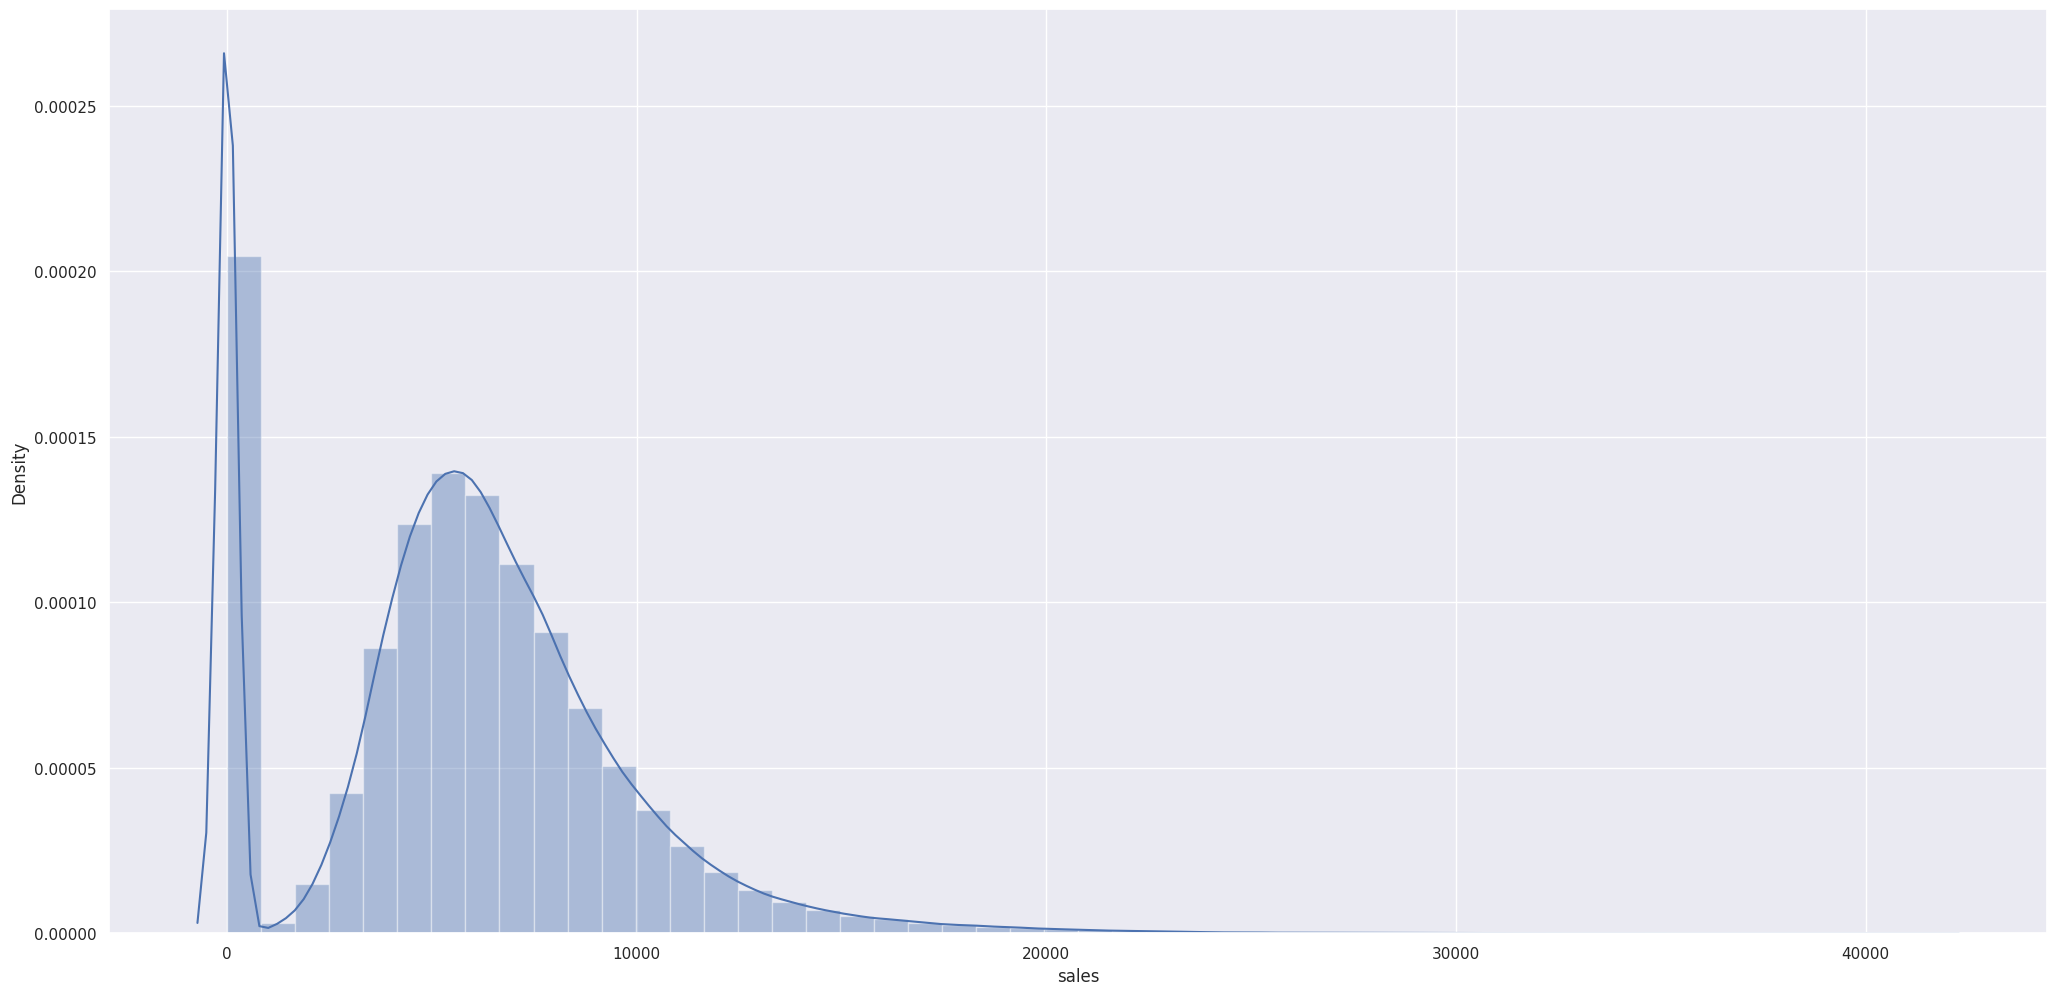

In [ ]:
sns.distplot( df1['sales']  )

<Axes: xlabel='competition_distance', ylabel='Density'>

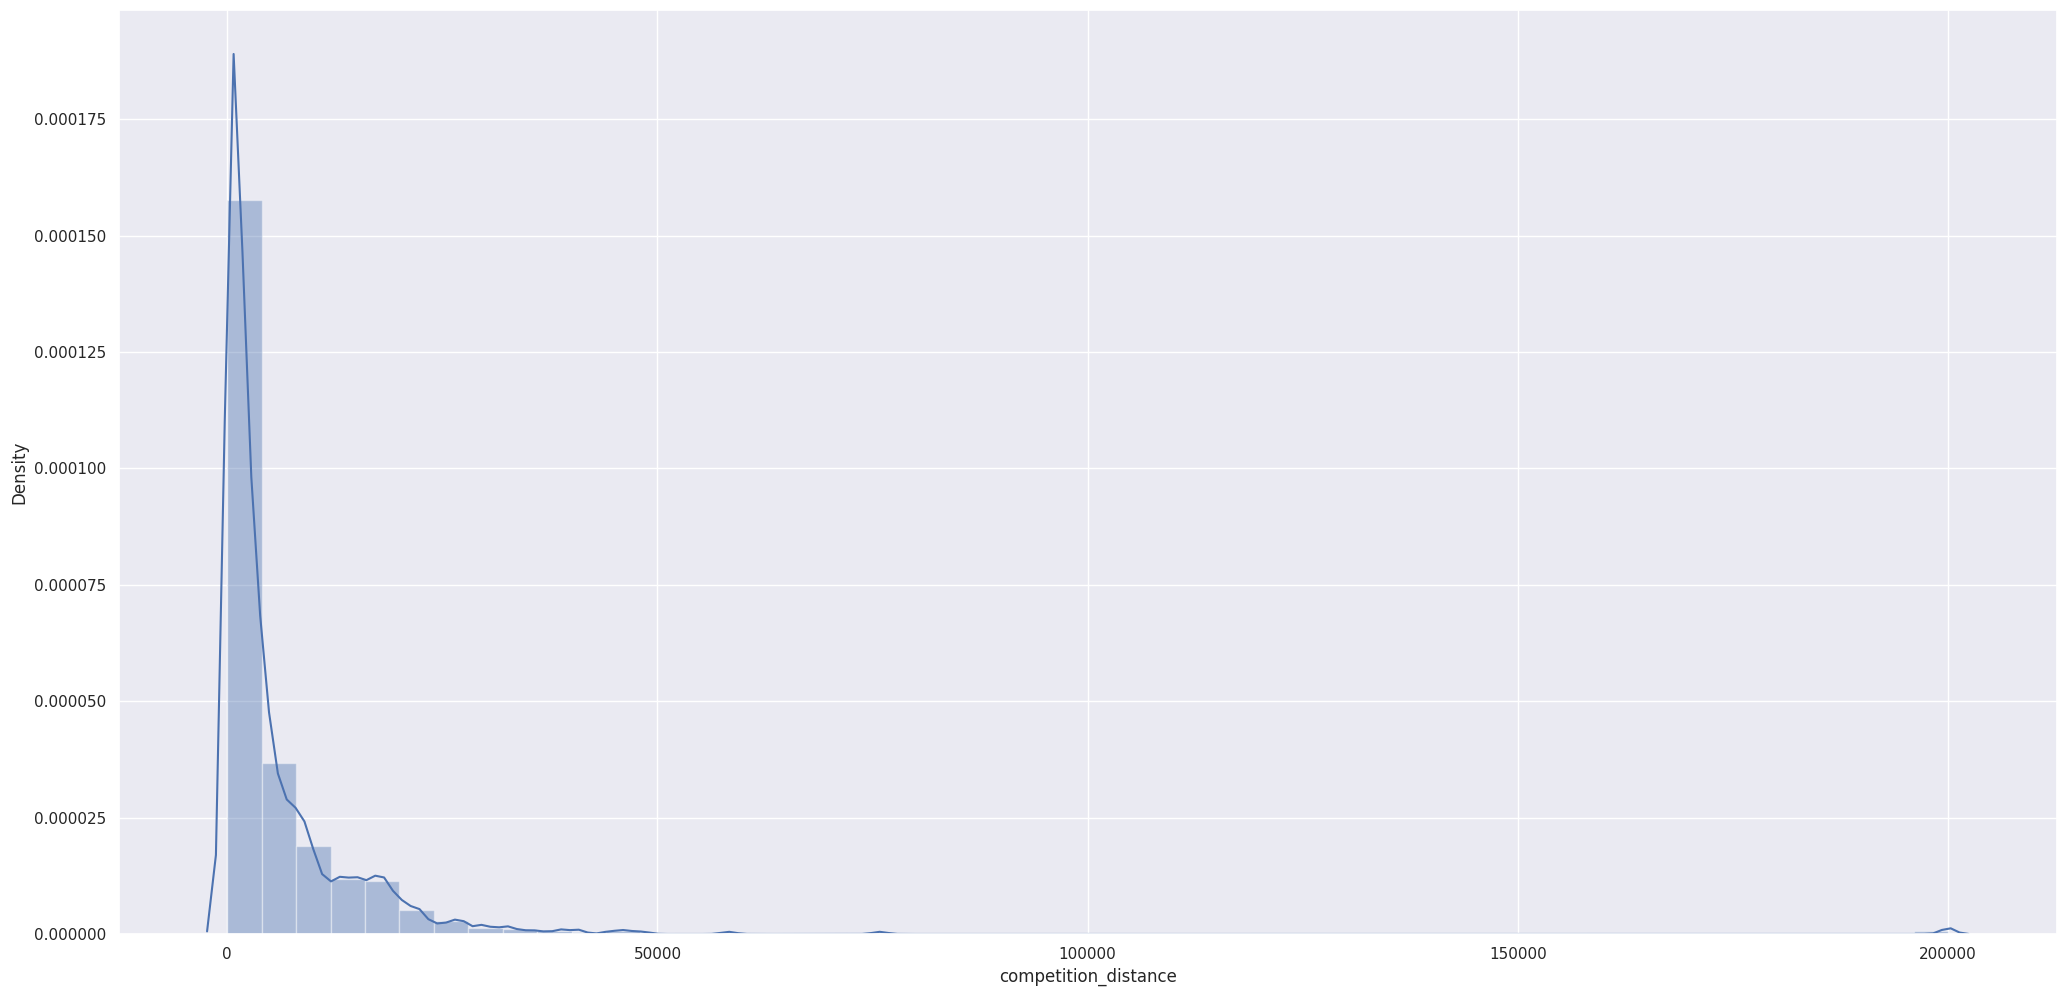

In [ ]:
sns.distplot( df1['competition_distance']  )

## 2.7.2 Categorical Atributos

In [ ]:
cat_atributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

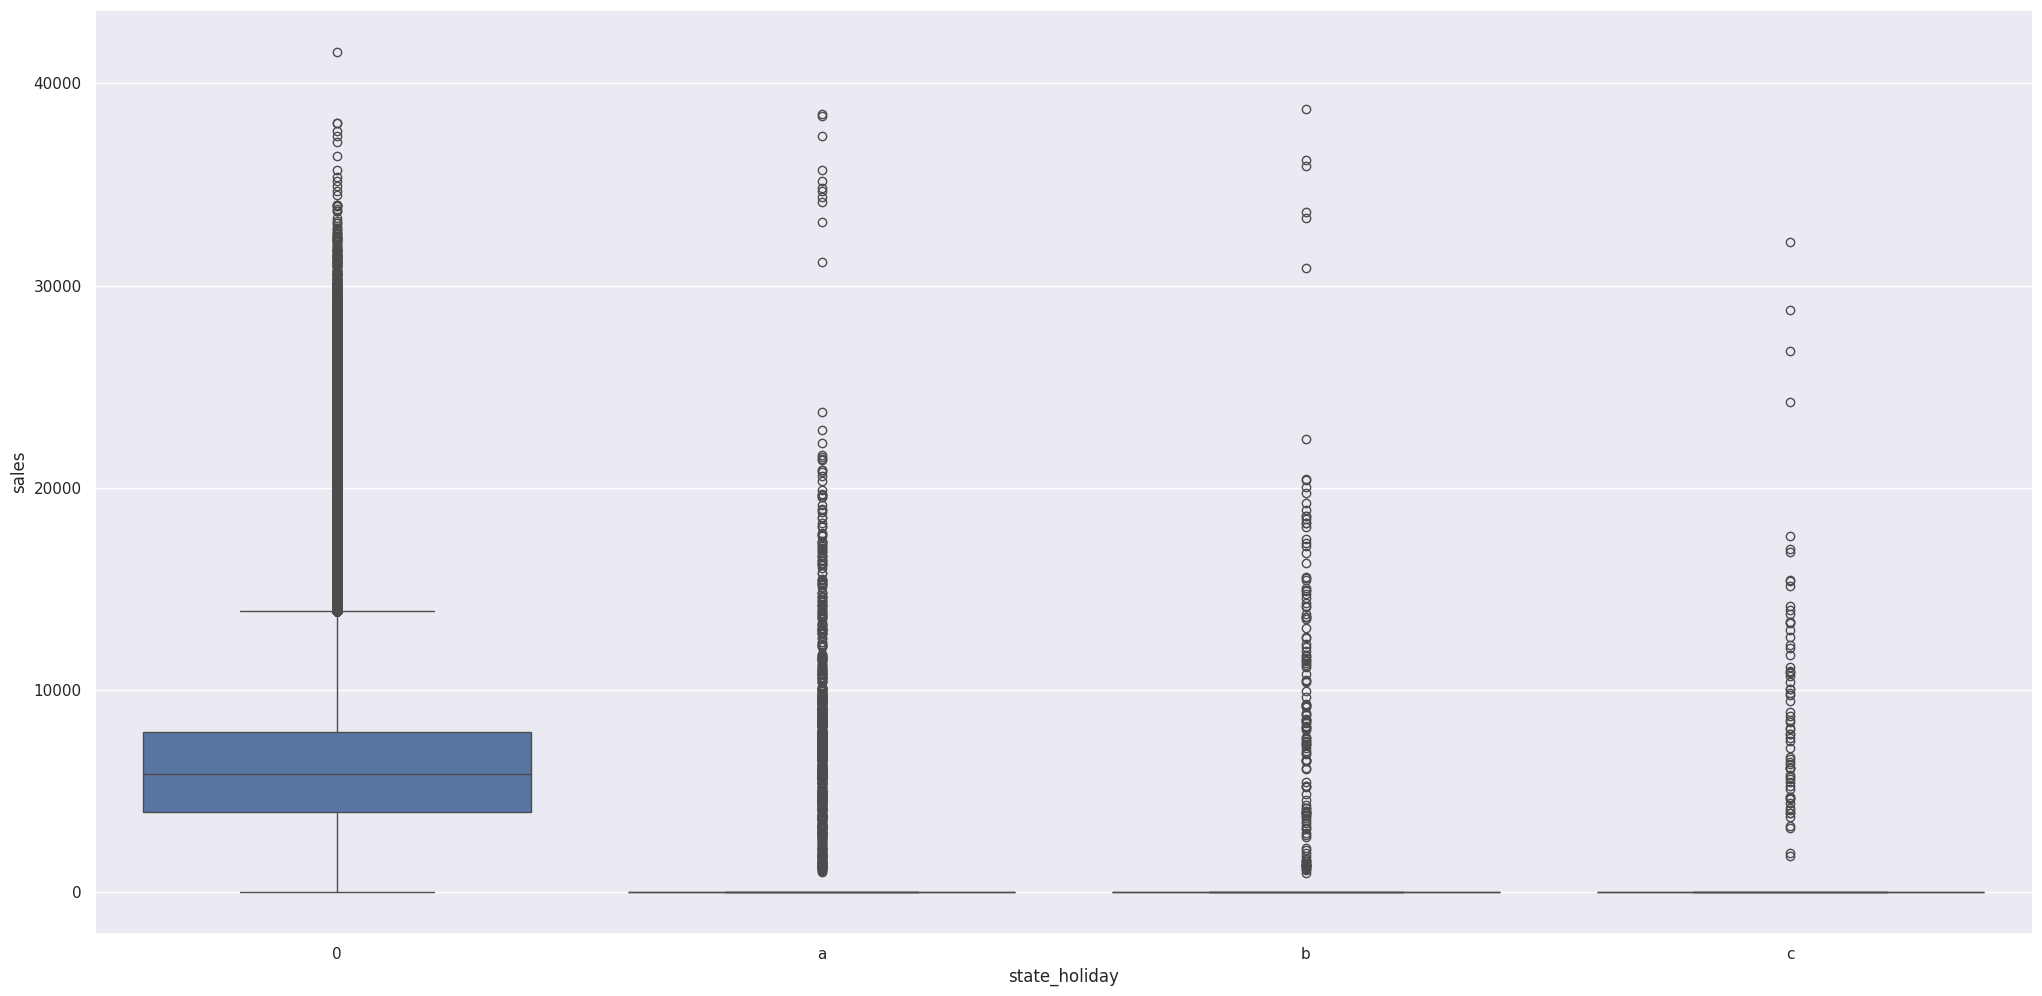

In [ ]:
sns.boxplot(x = 'state_holiday', y='sales' , data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

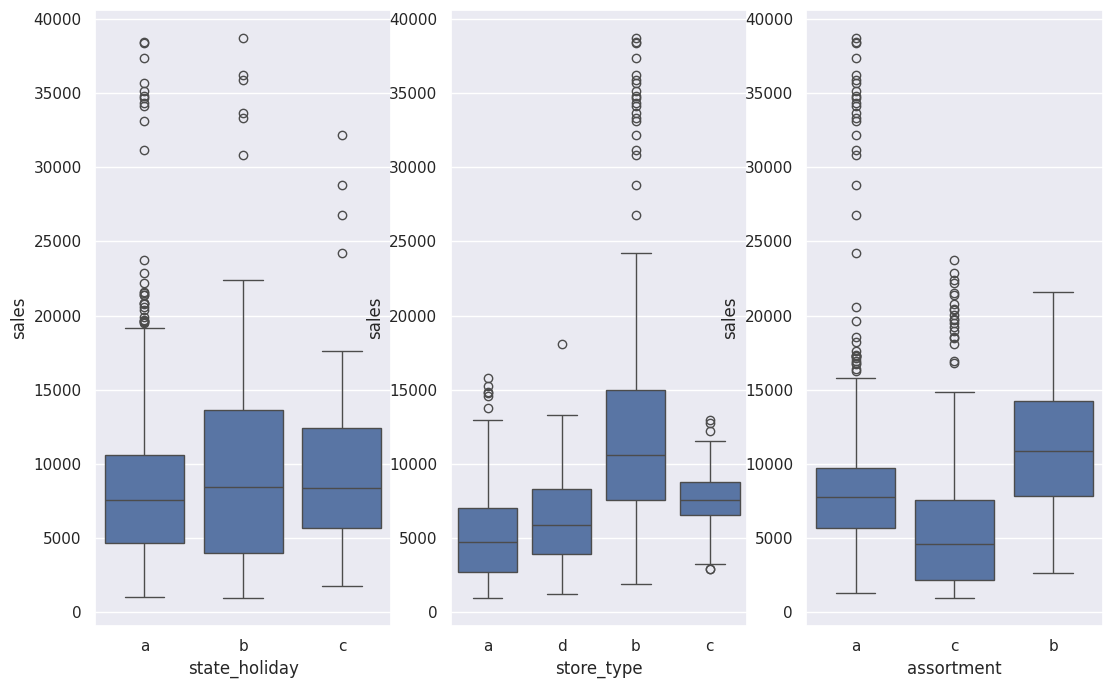

In [ ]:
# melhorando a visualização removedo dias que não vendeu
#StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais.
#Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado de Páscoa, c = Natal, 0 = Nenhum

aux1 = df1[ (df1['state_holiday'] != '0' ) & ( df1['sales']> 0 ) ]
plt.figure(figsize=(13, 8))

plt.subplot(1, 3, 1 )
sns.boxplot(x = 'state_holiday', y='sales' , data=aux1)


plt.subplot(1, 3, 2 )
sns.boxplot(x = 'store_type', y='sales' , data=aux1)


plt.subplot(1, 3, 3 )
sns.boxplot(x = 'assortment', y='sales' , data=aux1)




Como funciona boxplot
qual é a regra para outilier

# 3.0 Passo 02 - FEACTURE ENGINEERING

In [ ]:
df2 = df1.copy()

In [ ]:
#Image('img/MindMapHypothesis.png')

## 3.1. Criacao das Hipoteses

2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionário deveriam vende mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deverim vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Markting deveriam vender mais.

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem menor preços nos produtos deveriam vender mais.

**4.** Lojas que tem preço menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas cocm mais promoções consecutivas deveriam vender mais.



2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam venderr mais no segundo semeestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam venderr menos durante os feriados escolares


## 3.1.4 Hipoteses finais
vamos avaliar quais das hipóteses gerada eu tenho dados que me ajude a provar ou encontrar correlação.

                    --Lojas--

**1.** Lojas com maior sortimentos deveriam vender mais.

**1.** Lojas com competidores mais próximos deveriam vender menos.

**1.** Lojas com competidores á mais tempo deveriam vender mais
                    
                    --Tempo--

**1.** Lojas cbertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [ ]:
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )


df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )


df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )


df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
# assortment



df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


#  4.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [ ]:
df3 = df2.copy()

## 4.1. Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2. Selecao das Colunas

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

#  5.0. PASSO 05 - ANALISE EXPLORATORIA DOS DADOS

In [ ]:
df4 = df3.copy()

## 5.1 Analise Univariada

A análise univariada, parte fundamental da AED, concentra-se em uma única variável. Ela envolve classificar a variável quanto ao tipo (qualitativa ou quantitativa) e obter tabelas, gráficos e medidas que resumam essa variável12. Por exemplo, podemos calcular a média, mediana, moda e intervalo dos dados3

<Axes: xlabel='sales', ylabel='Density'>

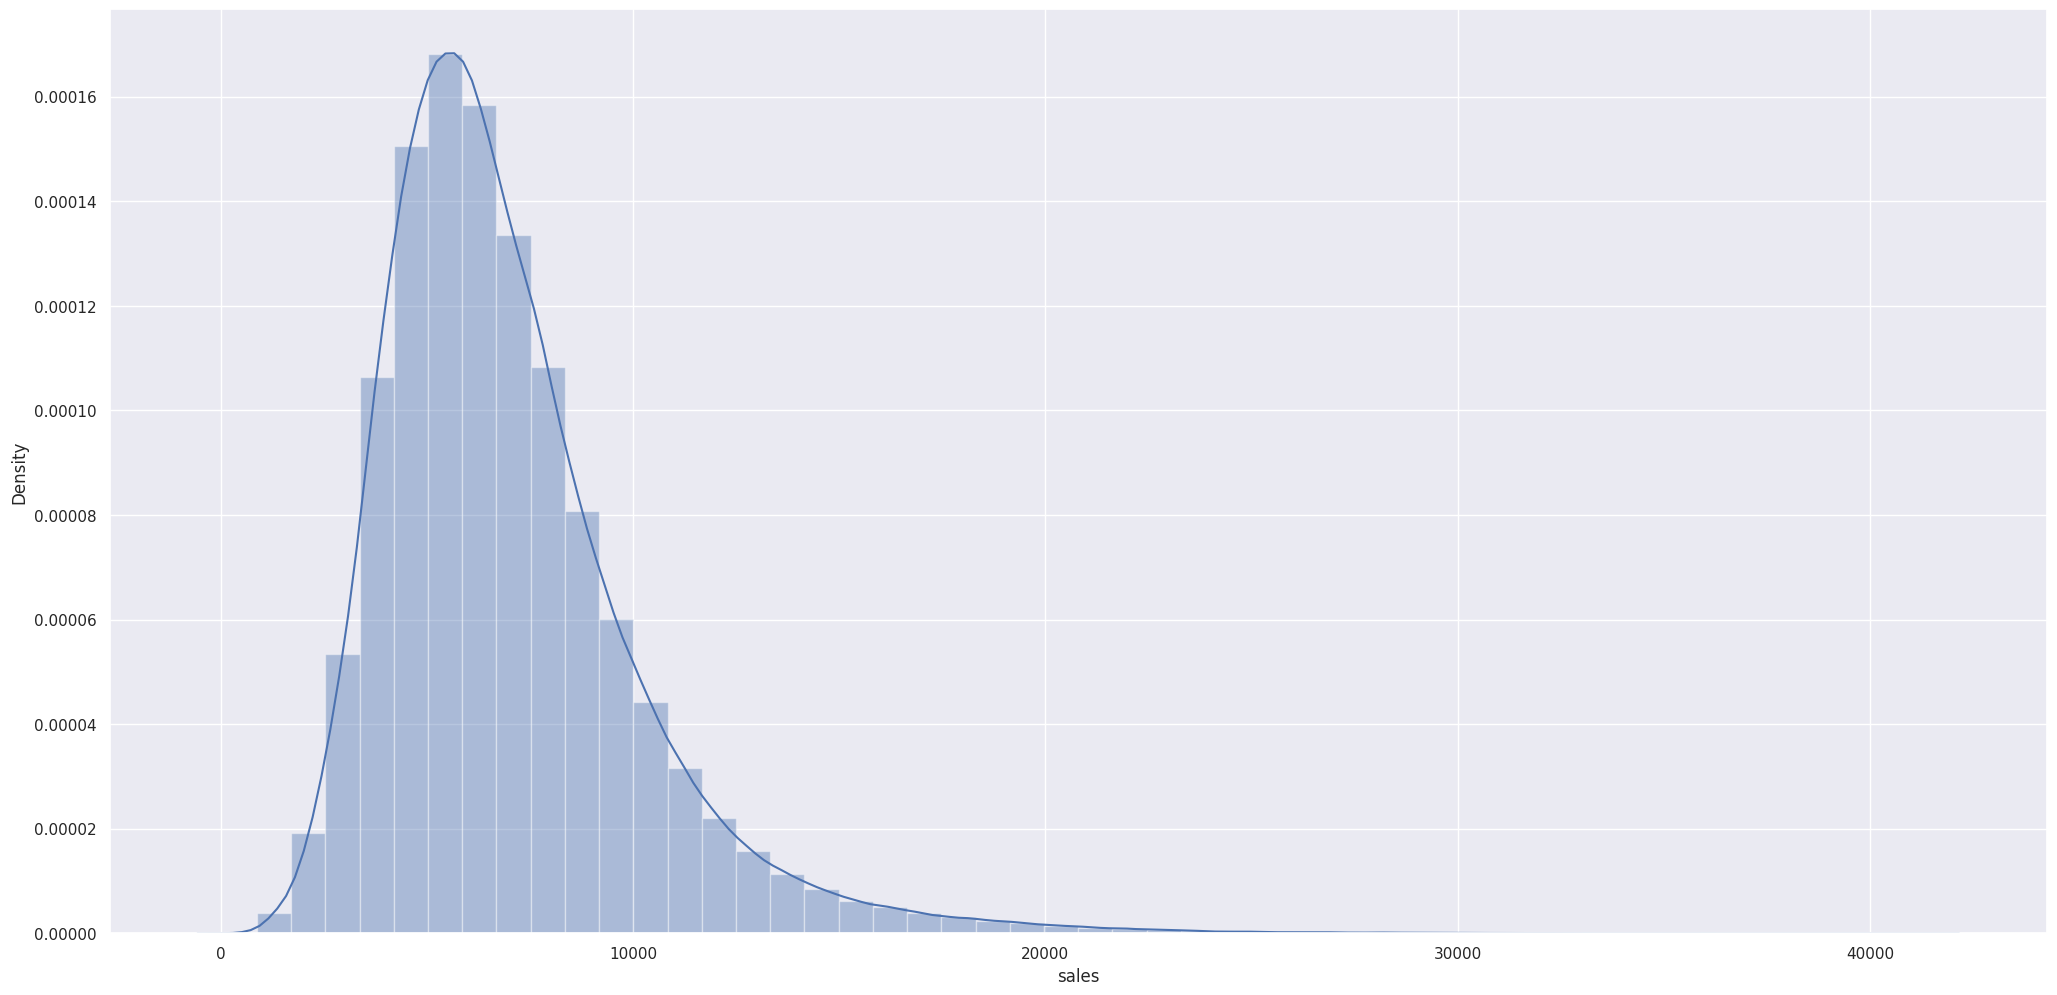

In [ ]:
sns.distplot( df4['sales'], kde=True)

## 4.1.2. Numerical Variable

O objetivo da AED é entender a natureza dos dados, identificar tendências e avaliar a qualidade dos dados. Não se trata apenas de criar visualizações sofisticadas; o foco é obter insights e respostas a partir dos dados. AED é uma prática iterativa, permitindo ajustes conforme novos insights surgem. Existem dois tipos principais de dados estruturados: variáveis categóricas (com valores finitos) e valores numéricos (contínuos).12

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

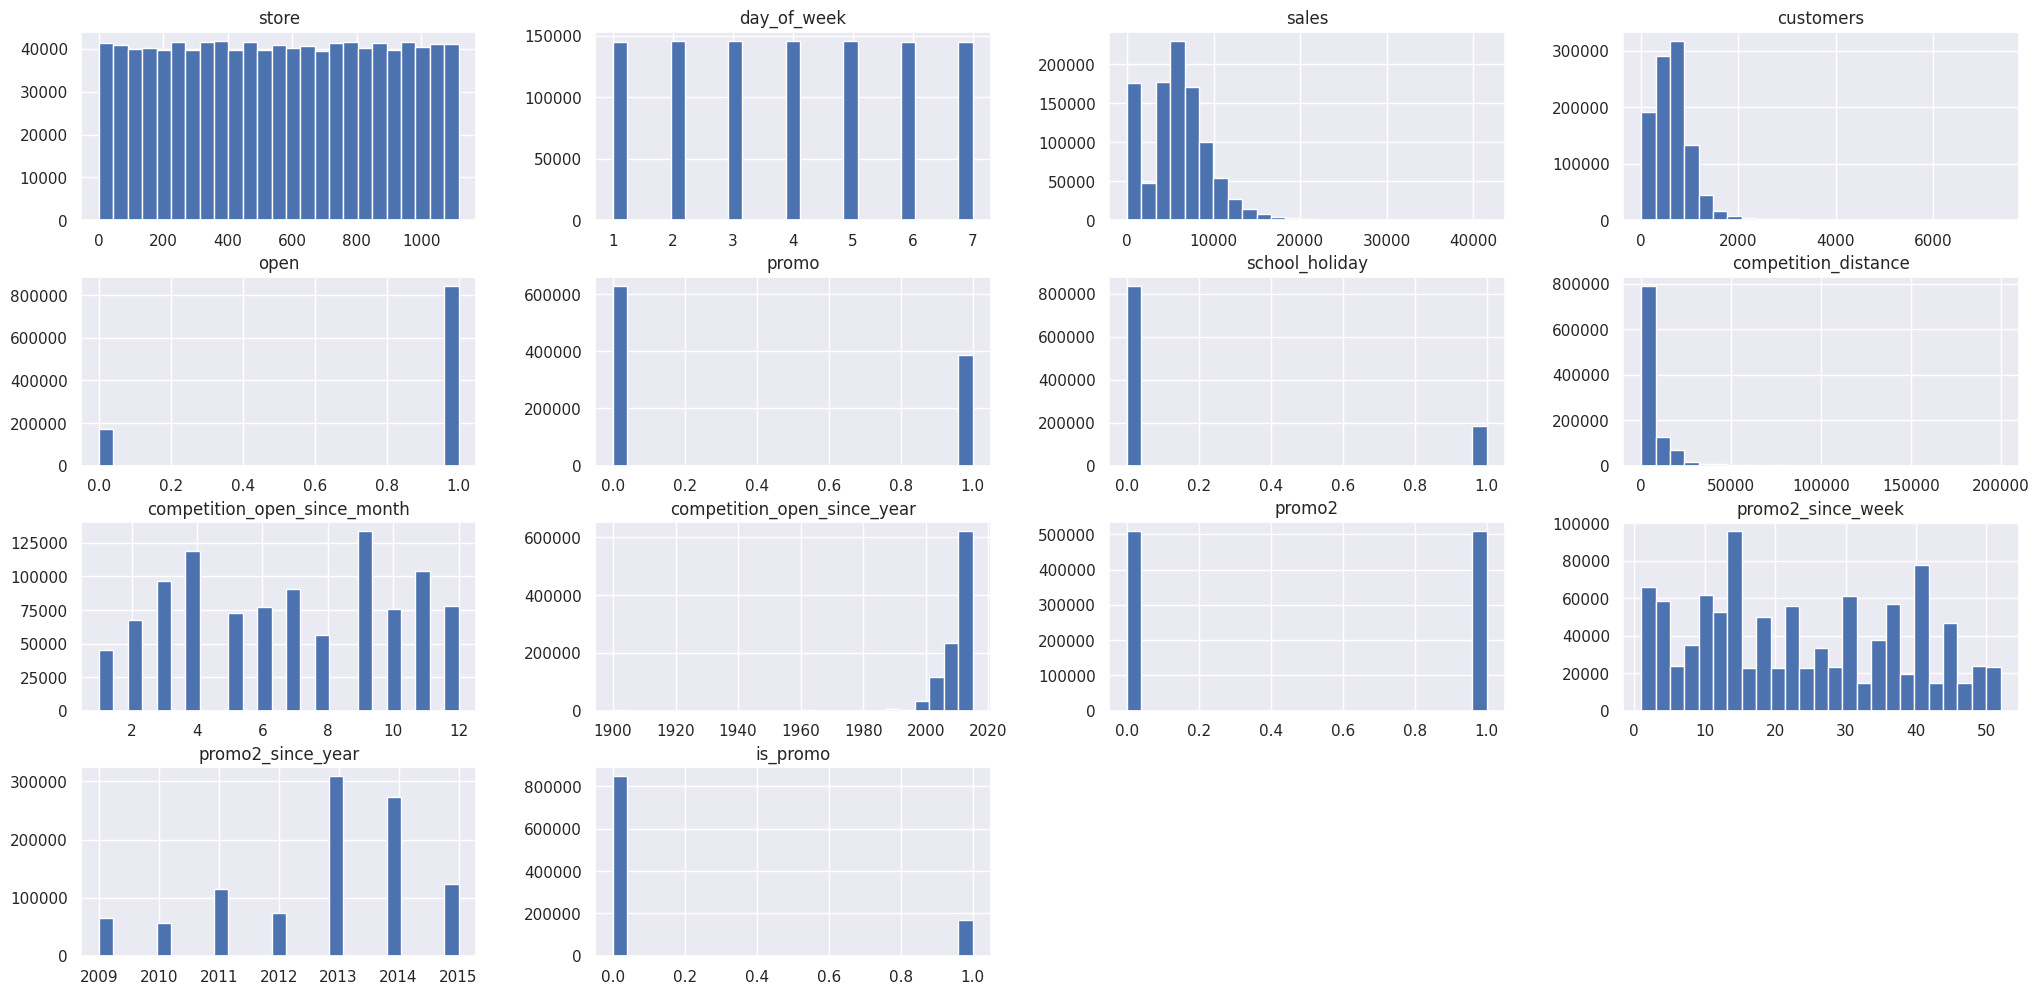

In [ ]:
num_atributes.hist( bins = 25)

## 5.2. Categorical Variable

In [ ]:
# Vamos viasualizar as variáveis categoricas
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable

<Axes: ylabel='Density'>

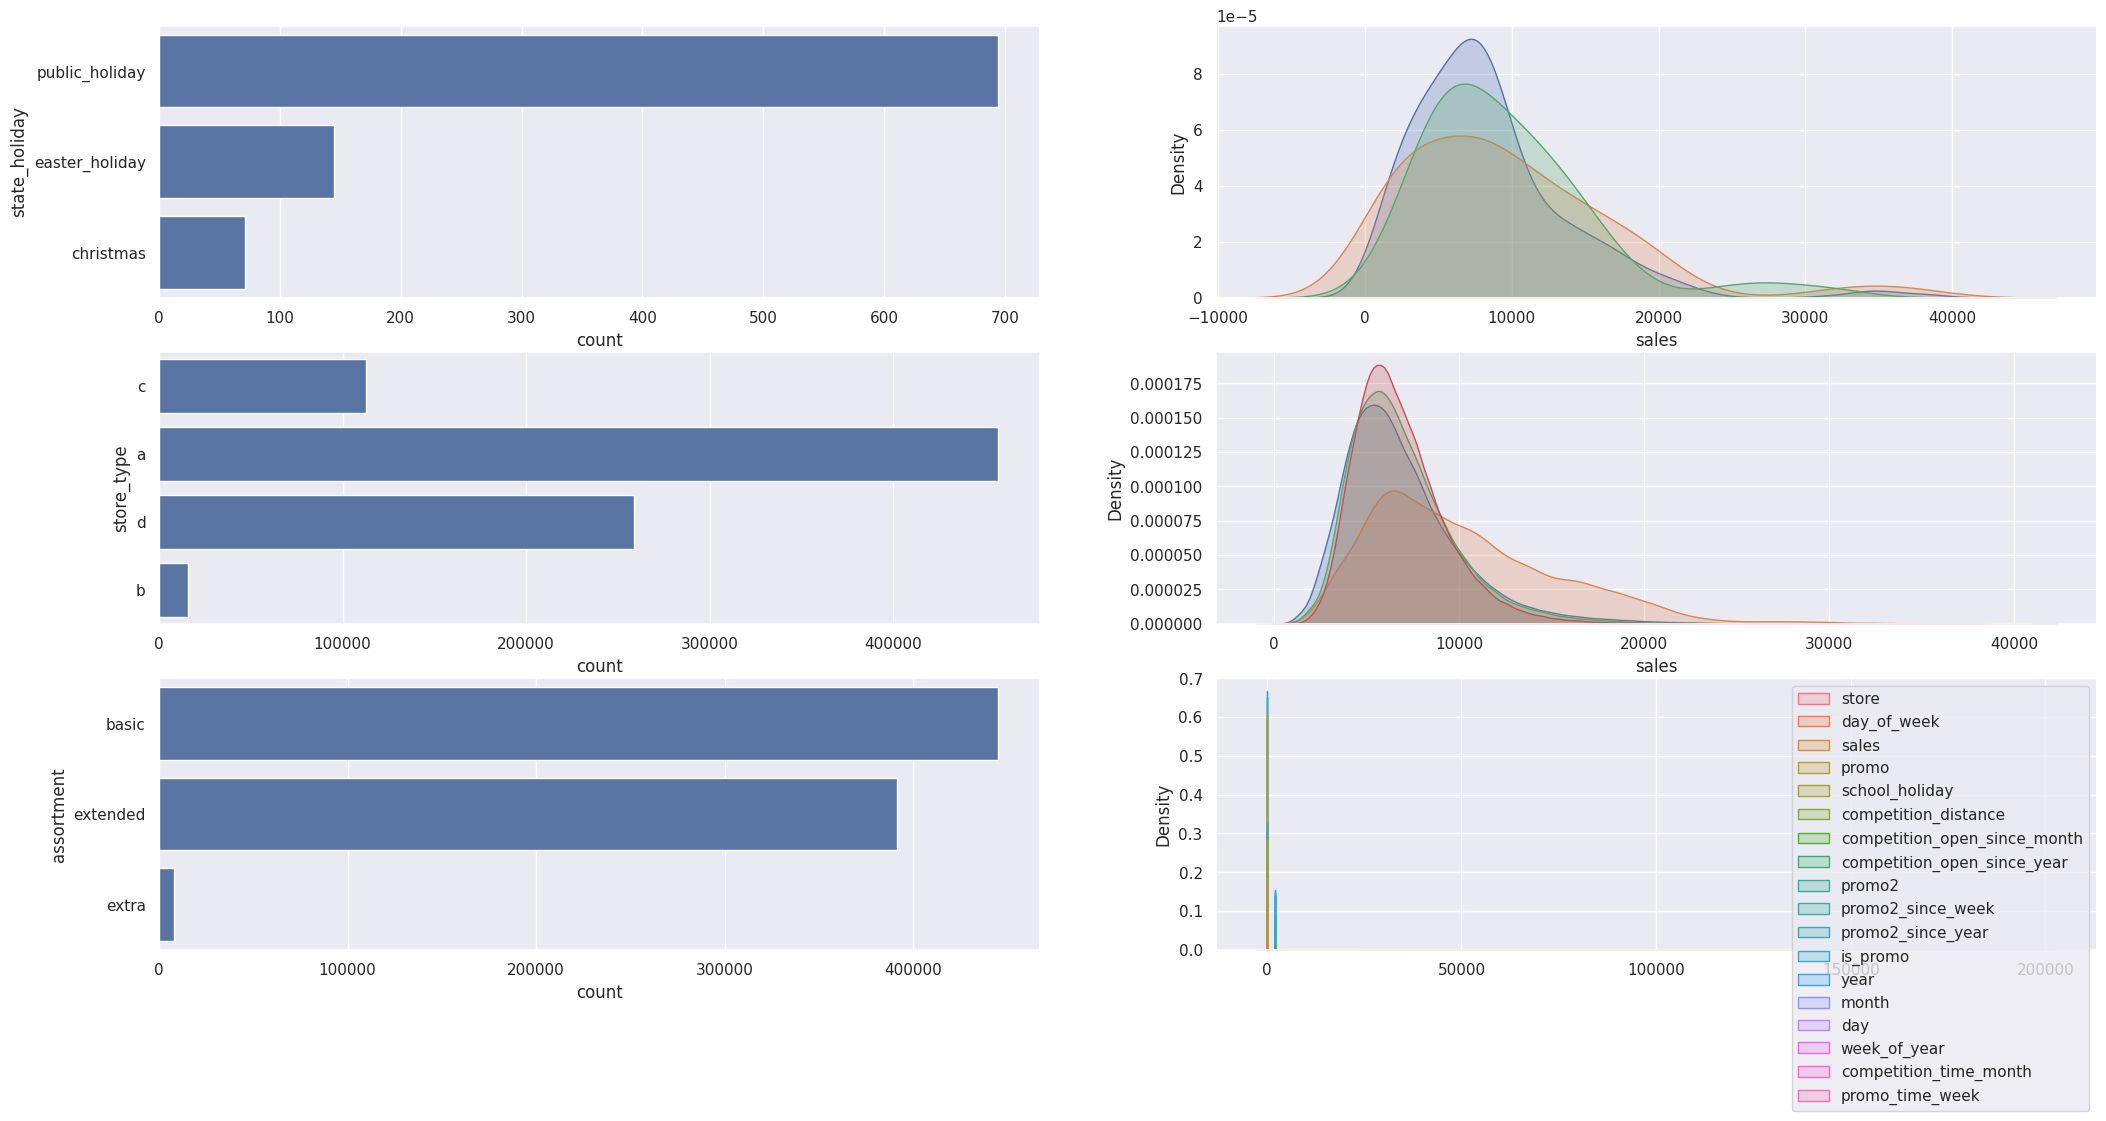

In [ ]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] );
#sns.countplot(a, x="state_holiday" );

plt.subplot(3, 2, 2);
sns.kdeplot(df4[ df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True,  legend=True )
sns.kdeplot(df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True,  legend=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True,  legend=True)

# store_type
plt.subplot(3 , 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label  = 'a', fill = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label  = 'b', fill = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label  = 'c', fill = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label  = 'd', fill = True)

# assortment
plt.subplot(3 , 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic'],    label = 'basic',    fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra'],    label = 'extra',    fill = True)

<Axes: xlabel='sales', ylabel='Density'>

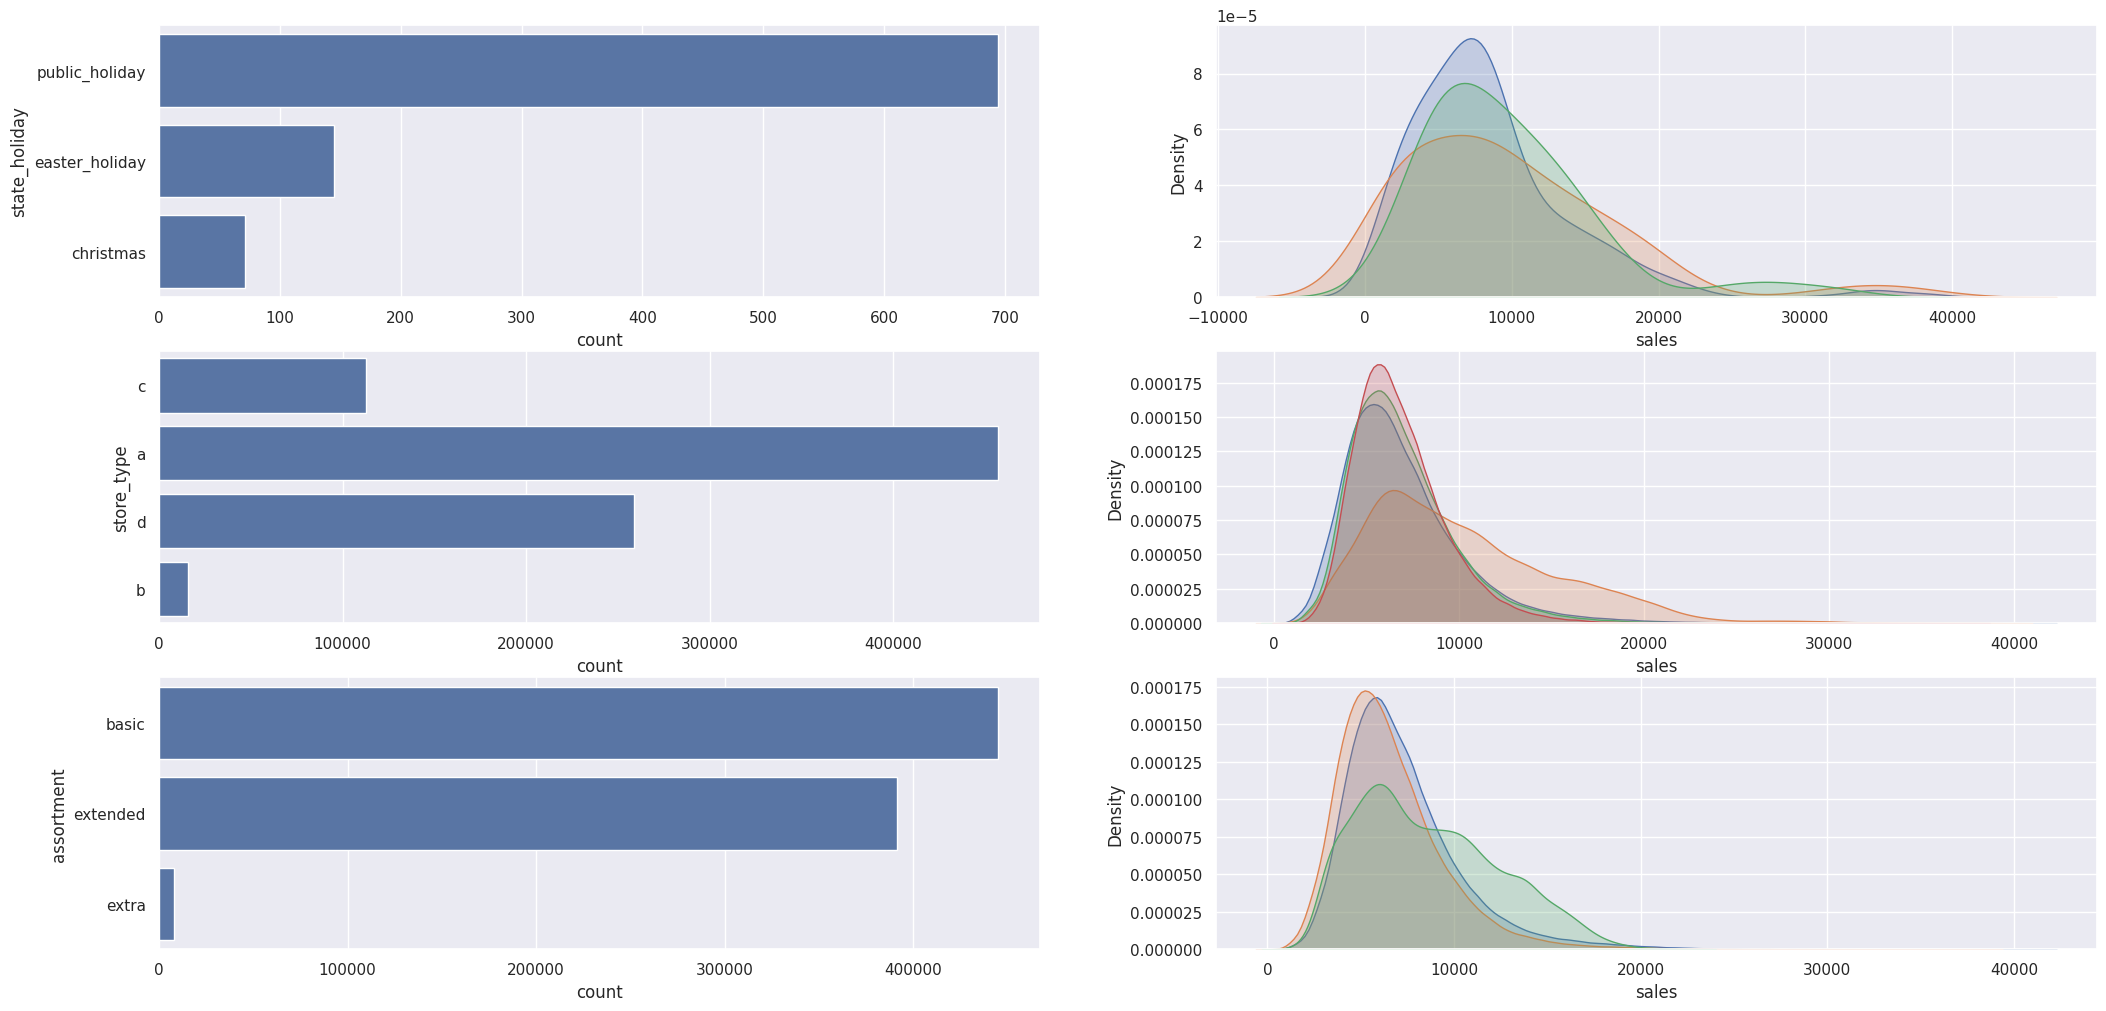

In [ ]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],    label='basic',    fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],    label='extra',    fill=True )

## 5.2. Analise Bivariada

### 5.2.1 H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

In [ ]:
a = df4.loc[:, ['assortment','sales'] ].groupby('assortment').sum()
a.head()

,sales
assortment,
basic,2945750070
extended,2856484241
extra,70946312


In [ ]:
aux1 = df4.loc[:, ['assortment','sales'] ].groupby('assortment').sum().reset_index()
a.head()

,sales
assortment,
basic,2945750070
extended,2856484241
extra,70946312


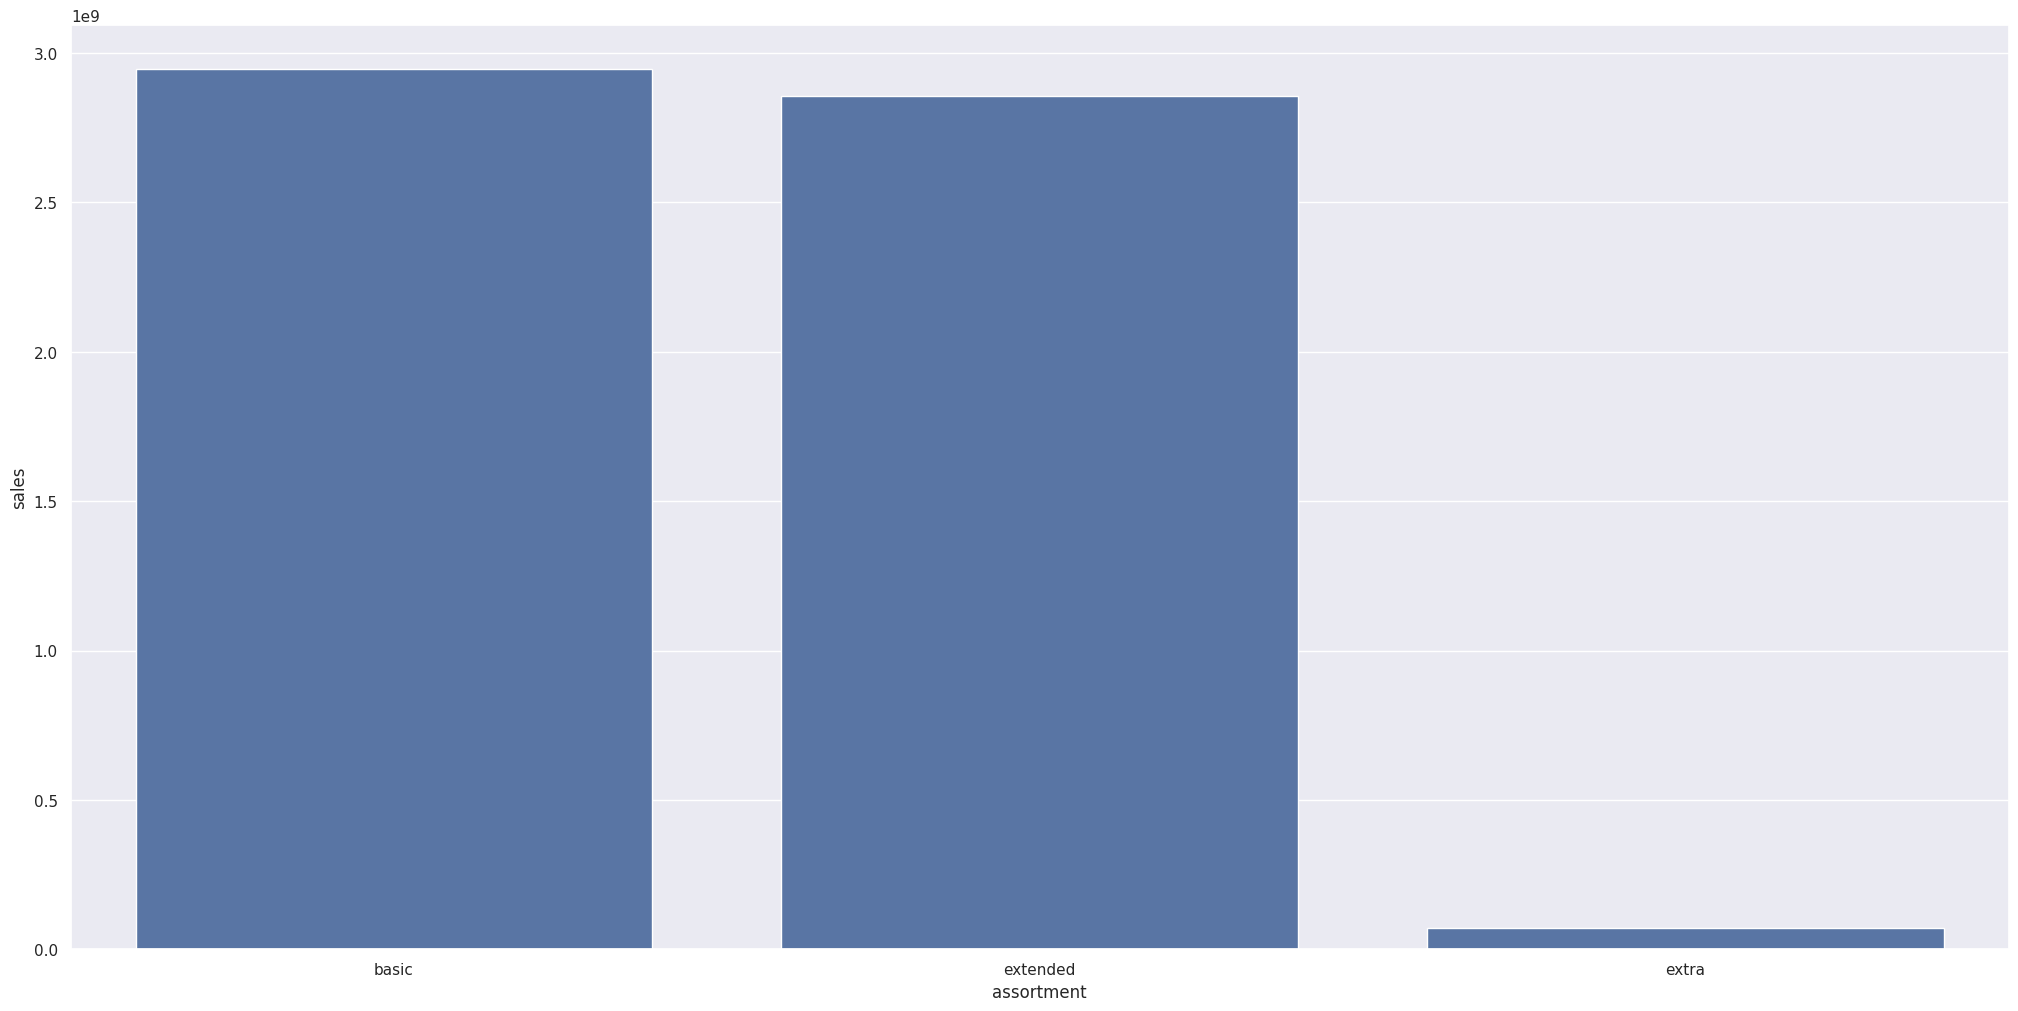

In [ ]:
sns.barplot( x='assortment', y='sales', data=aux1 );

observe que extra tem menos na soma geral, de todas as lojas, vamos agora ver o comportamento das vendas durante o ano.


In [ ]:
df4.head()

In [ ]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.head()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

observe que comportamento do 'basic' e 'extended' são próximos, e que o comportamento extra parece o quanto tendendo a linear, contudo, ele tem uma escala menor que os outros e pode estar sendo influenciado por isto.


In [ ]:
a = df4[df4['assortment'] == 'extra']

In [ ]:
aux3 = a[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()


Observe que ele não tem um comportamento que tende a linear, como gráfico anterior mostra!

### 5.2.2 H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

Pandas cut() function is used to separate the array elements into different bins . The cut function is mainly used to perform statistical analysis on scalar data

In [ ]:
# sales, competition_distance. aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
#aux1.head(5)
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
bins = list( np.arange( 0, 20000, 1000) ) # [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index();

sns.barplot(x = 'competition_distance_binned', y = 'sales', data= aux2);
plt.xticks( rotation = 90)


aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


In [ ]:
plt.figure(figsize=(16, 6))# Gera a figura
heatmap= sns.heatmap(aux1.corr(), annot=True); # aux1.corr() gera a correlação
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); # Adiciona título e formatação

heatmap o que é ?

o que é o método de pearson ?

### 5.2.3 H3. Lojas com competidores à mais tempo deveriam vendem mais.
FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [ ]:
#Quais anos estou trabalhando ?
#df4['year'].unique() -> array([2015, 2014, 2013])
#df4['competition_since'].unique() de 1998 a 2015 abriu lojas concorrentes

In [ ]:
df4['Duration_of_competition_in_years'] = df4['year'] - df4['competition_open_since_year'];

aux1 = df4[['Duration_of_competition_in_years', 'sales']].groupby('Duration_of_competition_in_years').sum().reset_index();
plt.subplot(1, 3, 1)
sns.scatterplot(x ='Duration_of_competition_in_years' , y ='sales' , data = aux1);
plt.xticks( rotation = 90);

plt.subplot(1, 3, 2)
sns.barplot(x ='Duration_of_competition_in_years' , y ='sales' , data = aux1)
plt.xticks( rotation = 90);


In [ ]:
#Como o professor fez
plt.subplot( 1, 3, 1 )
#Agrupando os dados que interessam
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()

#seleção das variáveis importante e descartar o que não serve!
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )

# Gerando um gráfico de regressão aos dados fornecido
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

# Correlação
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### 5.2.4 H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

 Quais variáveis estão envolvidas
 *promo
 *promo2
 *promo2_since_week
 *promo2_since_year
 * Observar à página Kaggle sobre a datas da promo
 Detalhes
 *store_type
 *assortment
 *competition_distance
 *competition_open_since_month
 *competition_open_since_year

In [ ]:
df4.head()

In [ ]:
colunas = ['sales','promo_since',	'promo_time_week',
            'is_promo',	'year',	'month',	'day',	'week_of_year',	'year_week',
            'promo2',	'promo2_since_week',	'promo2_since_year',
            'date',	'promo', 'state_holiday'	]

In [ ]:
dp= df4.loc[:,colunas]
dp.dtypes

In [ ]:
dp = dp[dp['state_holiday'] == 'regular_day']

In [ ]:
dp.loc[:,['is_promo', 'promo2', 'promo']].head()

In [ ]:
# Tem duas condições, is_promo and promo2 são o filtro
# Vamos grupar sales, is_promo, promo2, promo2_since_week
# dp['month'].unique() [ 7,  6,  5,  4,  3,  2,  1, 12, 11, 10,  9,  8])
# Vamos gerar os seguintes gráficos
# primeira figura observar venda por mês vamos filtra pela promos

aux_p1 = dp[(dp['promo']  == 1) & (dp['promo2']  == 0)]

aux_p1 =  aux_p1[['sales', 'month', ]].groupby('month').sum().reset_index()


#---------------
aux_p2 = dp[(dp['promo2']  == 1) & (dp['promo']  == 0)]

aux_p2 =  aux_p2[['sales', 'month']].groupby('month').sum().reset_index()
#---------------
aux_p1_2 = dp[(dp['promo2']  == 1) & (dp['promo']  == 1)]

aux_p1_2 =  aux_p1_2[['sales', 'month']].groupby('month').sum().reset_index()
#---------------
aux_p0 = dp[(dp['promo2']  == 0) & (dp['promo']  == 0) ]

aux_p0 =  aux_p0[['sales', 'month']].groupby('month').sum().reset_index()





In [ ]:
aux_p1.head()

In [ ]:




aux_p1['sales_p1'] = aux_p1['sales']

aux_p2['sales_p2'] = aux_p2['sales']

aux_p1_2['sales_p1_2'] = aux_p1_2['sales']

aux_p0['sales_p0'] = aux_p0['sales']

df_sale = pd.merge( aux_p1, aux_p2, how = 'left', on = 'month' )
df_sals = pd.merge( aux_p0, aux_p1_2, how = 'left', on = 'month' )
df_sales = pd.merge( df_sale, df_sals, how = 'left', on = 'month' )

# Defina os valores para o eixo X (meses)
x = df_sales['month']

# Defina os valores para os eixos Y (vendas)
y1 = df_sales['sales_p1']
y2 = df_sales['sales_p2']
y3 = df_sales['sales_p1_2']
y4 = df_sales['sales_p0']

# Crie o gráfico de barras
plt.figure(figsize=(10, 10))
plt.bar(x, y1, label='Sales P1')
plt.bar(x, y2, label='Sales P2', bottom=y1)
plt.bar(x, y3, label='Sales P1+2', bottom=y1+y2)
plt.bar(x, y4, label='Sales P0', bottom=y1+y2+y3)

# Personalize o gráfico (título, rótulos etc.)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Product')
plt.legend()

# Exiba o gráfico
plt.yscale('log')

plt.show()



In [ ]:
df_sales.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
sns.kdeplot(aux_p1['sales'],   label='Promo 1', fill = True)
sns.kdeplot(aux_p2['sales'],   label='Promo 2',  fill = True)
sns.kdeplot(aux_p1_2['sales'], label='Promo 1 e 2', fill = True)
sns.kdeplot(aux_p0['sales'],   label='Sem Promoção', fill = True)

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


In [ ]:


# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']
# Atenção uma forma de colocar tudo em um gráfico só é juntar os dataset groups
# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
sns.scatterplot(x ='month' , y ='sales' , data = aux_p1,    legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p2,   legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p1_2,   legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p0,   legend='auto' )
# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
#plt.legend()

# Exiba o gráfico
plt.show()


In [ ]:
aux1 =  dp[['sales', 'is_promo', 'promo2', 'month', 'promo2_since_year']].groupby('month').sum()
aux1

In [ ]:
#
# sales pelo tempo de promoção gráfico 1 (na promo 1), gráfico 2 (na promo 2), gráfico 3 (na promo 1 e 2), gráfico 4 (sem promo) pela mês do ano
dp = dp[dp['promo_time_week'] > 0 ]

aux_p1 = dp[(dp['is_promo']  == 1) & (dp['promo2']  == 0)]

aux_p1 =  aux_p1[['sales', 'promo_time_week', ]].groupby('promo_time_week').sum().reset_index()


#---------------
aux_p2 = dp[(dp['promo2']  == 1) & (dp['is_promo']  == 0)]

aux_p2 =  aux_p2[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
#---------------
aux_p1_2 = dp[(dp['promo2']  == 1) & (dp['is_promo']  == 1)]

aux_p1_2 =  aux_p1_2[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
#---------------
aux_p0 = dp[(dp['promo2']  == 0) & (dp['is_promo']  == 0) ]

aux_p0 =  aux_p0[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()

In [ ]:
dp['promo_time_week'].unique()

In [ ]:


# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))


sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p1, label='Promo 1 ')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p2 ,label='Promo 2')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p1_2 ,label='Promo 1 e 2')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p0 ,label='Sem promo')

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))


sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p1, label='Promo 1 ')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p2 ,label='Promo 2')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p1_2 ,label='Promo 1 e 2')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p0 ,label='Sem promo')

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


In [ ]:
#Professor fez

#Agrupa as informações
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
# Mostra um gráfico de regressão com scaterr, uma tendência dos ponto
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x ='promo_time_week', y ='sales', data=aux2 );



plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

~5.2.5 H5. Lojas com mais dias de promoção deveriam vender mais.~
## 5.2.6 H7. Lojas com mais promoções consecutivas deveriam vender mais.
FALSA Lojas com mais promocoes consecutivas vendem menos

In [ ]:
#Segundo a HIPÓTESE a ser analisada existem dois tipos de LoJAS que promoções consecutivas e não promoções consecutivas, vamos dividir em:
# Quais colunas vamos usar ?
#df4.head()
aux= df4[df4['state_holiday'] == 'regular_day']
#retirar as lojas que não entraram na promo 1
aux_p= df4[df4['promo'] != 0]
# Vamos retirar também os dados de 2015 pois não estão completos,embora é seja perca de dados, vai nos dar velocidade!
aux_p = df4[df4['year'] != 2015]
# agora temos somente lojas que entraram na promo 1 e talvez entraram na promo2
# As colunas analisada são :
# sales, promo2 promo2_since_week
#
aux_p1 = aux_p[['sales', 'promo2', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
aux_p.head()

In [ ]:
aux2 = aux_p[['sales', 'promo2' ]].groupby('promo2').sum().reset_index()
aux2.head()
sns.barplot( x='promo2', y='sales', data=aux2, legend = 'full' );
#de forma geral venderam mais quem não extendeu para promo 2, vamos agora observar a tentendência!

In [ ]:
aux3 = aux_p[['sales', 'promo2', 'promo_time_week']].groupby(['promo2','promo_time_week']).sum().reset_index()
# vamos analisar o range da promo_time_week
#aux3['promo_time_week'].unique() #primeiro momento existem valores negativos, vamos filtra-los
aux3 =  aux3[aux3['promo_time_week']>0]
aux3 = aux3[aux3['sales'] < 18000000] #Removendo outlier
#aux3['promo_time_week'].unique() # ele vai de 1 a 283
#vamos dividir em duas partes, gerando três gráficos
aux31 = aux3[aux3['promo_time_week'] < 94 ]
aux32 = aux3[(aux3['promo_time_week']  >= 94) & (aux3['promo_time_week']  < 188) ]
aux33 = aux3[aux3['promo_time_week']  >= 188 ]
#aux3


In [ ]:
# como os outilier estão atrapalhando a escala do gráfico vou remover esses que são muito fora da curva.
aux3['sales'].agg(['max', 'min', 'mean', 'median', 'std'] )


In [ ]:
#subplot(linha, coluna, posição)
#aux3.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

#plt.subplot(3, 1 , 1)
aux31.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

#sns.regplot(x = 'promo_time_week', y = 'sales', data = aux31) # Nota se um outilier que atrapalha a visualização, está em prim_time_week  0







In [ ]:
#plt.subplot(3, 1, 2)
aux32.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

In [ ]:
#plt.subplot(3, 1, 3)
aux33.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

In [ ]:
#Professor fez

df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


In [ ]:
#Professor fez
# Selecionou agrupando três colunas: ['promo', 'promo2', 'sales']
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


In [ ]:
#realizou um filtro para promo e promo2 ativato e selecionandos as colunas ['year_week', 'sales'] e indexando year_week.
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

#realizou um filtro para promo ativato e promo2 n ativato e selecionandos as colunas ['year_week', 'sales'] e indexando year_week.
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

## 5.2.7 H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.

In [ ]:
df4.head(3)

Quais colunas estamos trabalhando ?
 * sales
 * state_holiday -> options: 'regular_day', 'public_holiday', 'easter_holiday', 'christmas'
 *
Quais feriados vendem mais ?
Um Feriado de natal vende mais que um dia normal ?

In [ ]:
aux_c = df4[df4['state_holiday'] == 'christmas']#agg({'sales' : ['max']})
aux_c = aux_c.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_c

In [ ]:

aux_r = df4[df4['state_holiday'] == 'regular_day']
aux_r = aux_r.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_r.head(4)

In [ ]:
aux_p = df4[df4['state_holiday'] == 'public_holiday']
aux_p = aux_p.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_p.head(4)

In [ ]:
aux_e = df4[df4['state_holiday'] == 'easter_holiday']
aux_e = aux_e.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_e = aux_e.iloc[0:4, :].reset_index()

In [ ]:
aux_e

In [ ]:

#aux_e[0,'index'] = 1
#aux_e[1,'index'] = 2
#aux_e[2,'index'] = 3
#aux_e[3,'index'] = 4

#aux_e = aux_e.rename(columns={'index': 'podio')

#df3 = df3.drop( ['date'], axis=1 )


In [ ]:
#forma que Professor fez!
#faz um filtro e plota
aux = df4[df4['state_holiday'] != 'regular_day']
# agrupa e soma as vendas em dias n comum
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

## 5.2.8 H9. Lojas deveriam vender mais ao longo dos anos.
Próximo de falsa - pois no ano de 2015  falta dados da metade do ano, que vinha de forma promissora para ser o melhor ano de vendas. Além disso, o que ocorreu em 2014, uma grande queda pós o mês 6, pode ser um acontecimento promovido por algo específico da aquele ele, que existe baixa possibilidade de repetir, já o ano de 2014 estava com números de vendas um pouco melhor que 2013 nos primeiros 6 mêses, exceto fevereiro de 2013.

In [ ]:
df4.head()

Vamos pegar as colunas
 * sales
 * year
 * month
    Então vamos ferar dois ✌ tipos de gráficos, um gráfico acumulativo de vendas anual, outro um pivot por mesês, sendo três anos serão três linhas

In [ ]:
# Acumulativo
aux = df4[['sales','year']].groupby('year').sum().reset_index()

plt.subplot(2,1, 1 )
sns.barplot(x = 'year' ,y = 'sales', data = aux)
# Tendência anual
plt.subplot(2, 1, 2)
aux1 = df4[['sales','year', 'month']].groupby(['year', 'month']).sum().reset_index()
#aux1
aux1.pivot(index = 'month' , columns = 'year', values = 'sales').plot()


In [ ]:
## Como o professor fez !
# como eu selecionou sales e year, mas não month
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
# Criou gráfico de vendas acumulativo por ano
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )

# criou um regressão para analisar comportamento por anos
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
# Fez uma correlação das variáveis sales e year, o que para mim, não valia a pena para prever ou confiar acontecimentos futuros.
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 5.2.9 H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

In [ ]:
#o gráfico da pergunta anterior para analisar o comportamento das vendas em relação aos anos, deixa claro que as vendas diminuir
#após o mês 6, significativamente, tendo uma retomada no mês de Novembro a Dezembro.
# Acumulativo
aux = df4[['sales','year']].groupby('year').sum().reset_index()

aux1 = df4[['sales','year', 'month']].groupby(['year', 'month']).sum().reset_index()
#aux1
aux1.pivot(index = 'month' , columns = 'year', values = 'sales').plot()

In [ ]:
# como o professor fez!
# Agrupou por vendas por mês
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
# fez uma correlação com método de peason entre vendas e meses!
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 5.2.10 H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.


As colunas analisada são:
 * sales
 * year
 * month
 * day

In [ ]:
df4['day'].unique()

In [ ]:
#aux = df4[df4['day'] > 10]
#aux1 =  aux[['day','sales']].groupby(['day']).sum()

#aux2 = df4[df4['day'] < 10]
#aux3 =  aux2[['day','sales']].groupby(['year','month','day']).sum()

#vamos descartar o ano 2015 pois não está completo
aux = df4[df4['year'] != 2015]
aux1 =  aux[['day','sales']].groupby(['day']).sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1)



In [ ]:
 aux1['day'].unique()

In [ ]:
#import numpy as np

## Suponha que seu DataFrame seja chamado 'df'
aux1['day'] = np.where(aux1['day'] <= 10, 'before', 'after') # Se rodar duas vezes essa linha dar erro
aux2 = aux1[['sales', 'day']].groupby('day').sum()#.reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux2 )


In [ ]:
#Como o professor fez!
# Selecinou as duas variáveis envolvidas
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
#plotou elas em regressão
sns.regplot( x='day', y='sales', data=aux1 );

#fez uma correlação
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

## 5.2.11 H12. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA Lojas vendem menos nos final de semana

In [ ]:
df4.head(4)

 Quais colunas ou entidades que estão envolvidas :
 * sales
 * day_of_week
 *


In [ ]:
aux

In [ ]:

aux = df4[['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

#aux.astype(int)
plt.subplot(2, 1 , 1)
sns.barplot(x =  'day_of_week', y =  'sales', data = aux)

plt.subplot(2, 1 , 2)
sns.heatmap(aux.corr( method = 'pearson'), annot = True )


In [ ]:
# como o professor fez
#Selecionou duas culnas dias da semana e vendas
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



## 5.2.12 H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, except os meses de Julho e
Agosto.

As colunas que trazem a resposta a hipóteses são:
 * sales
 * year
 * month

In [ ]:
#promo_interval
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May',
 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9: 'Sep', 10: 'Oct', 11 :'Nov', 12 : 'Dec'}





In [ ]:
df4['school_holiday'].unique()

In [ ]:
#aux = df4[df4 ['school_holiday'] == 1 ]

aux = df4[['school_holiday','month','sales']].groupby(['school_holiday','month']).sum().reset_index()



aux.pivot(index= 'month' ,  columns = 'school_holiday', values ='sales' ).plot()

In [ ]:
#Como professor fez!
# Ele selecionou duas
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



## 5.2.13  Resumo das Hipoteses


In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

# 5.3  Analise Multivariada

## 5.3.1 Numerical Attributes


In [ ]:
correlation = num_atributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

In [ ]:
a.head(4)

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
#a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
#a2 = cramer_v( a['state_holiday'], a['store_type'] )
#a3 = cramer_v( a['state_holiday'], a['assortment'] )

#a4 = cramer_v( a['store_type'], a['state_holiday'] )
#a5 = cramer_v( a['store_type'], a['store_type'] )
#a6 = cramer_v( a['store_type'], a['assortment'] )
#a7 = cramer_v( a['assortment'], a['state_holiday'] )
#a8 = cramer_v( a['assortment'], a['store_type'] )
#a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
#d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  #  'store_type'  : [a4, a5, a6],
                  #  'assortment'  : [a7, a8, a9] })
#d = d.set_index( d.columns )
#sns.heatmap( d, annot=True )


# 6. PASSO 6 -  DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 6.1 -  Normalização

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

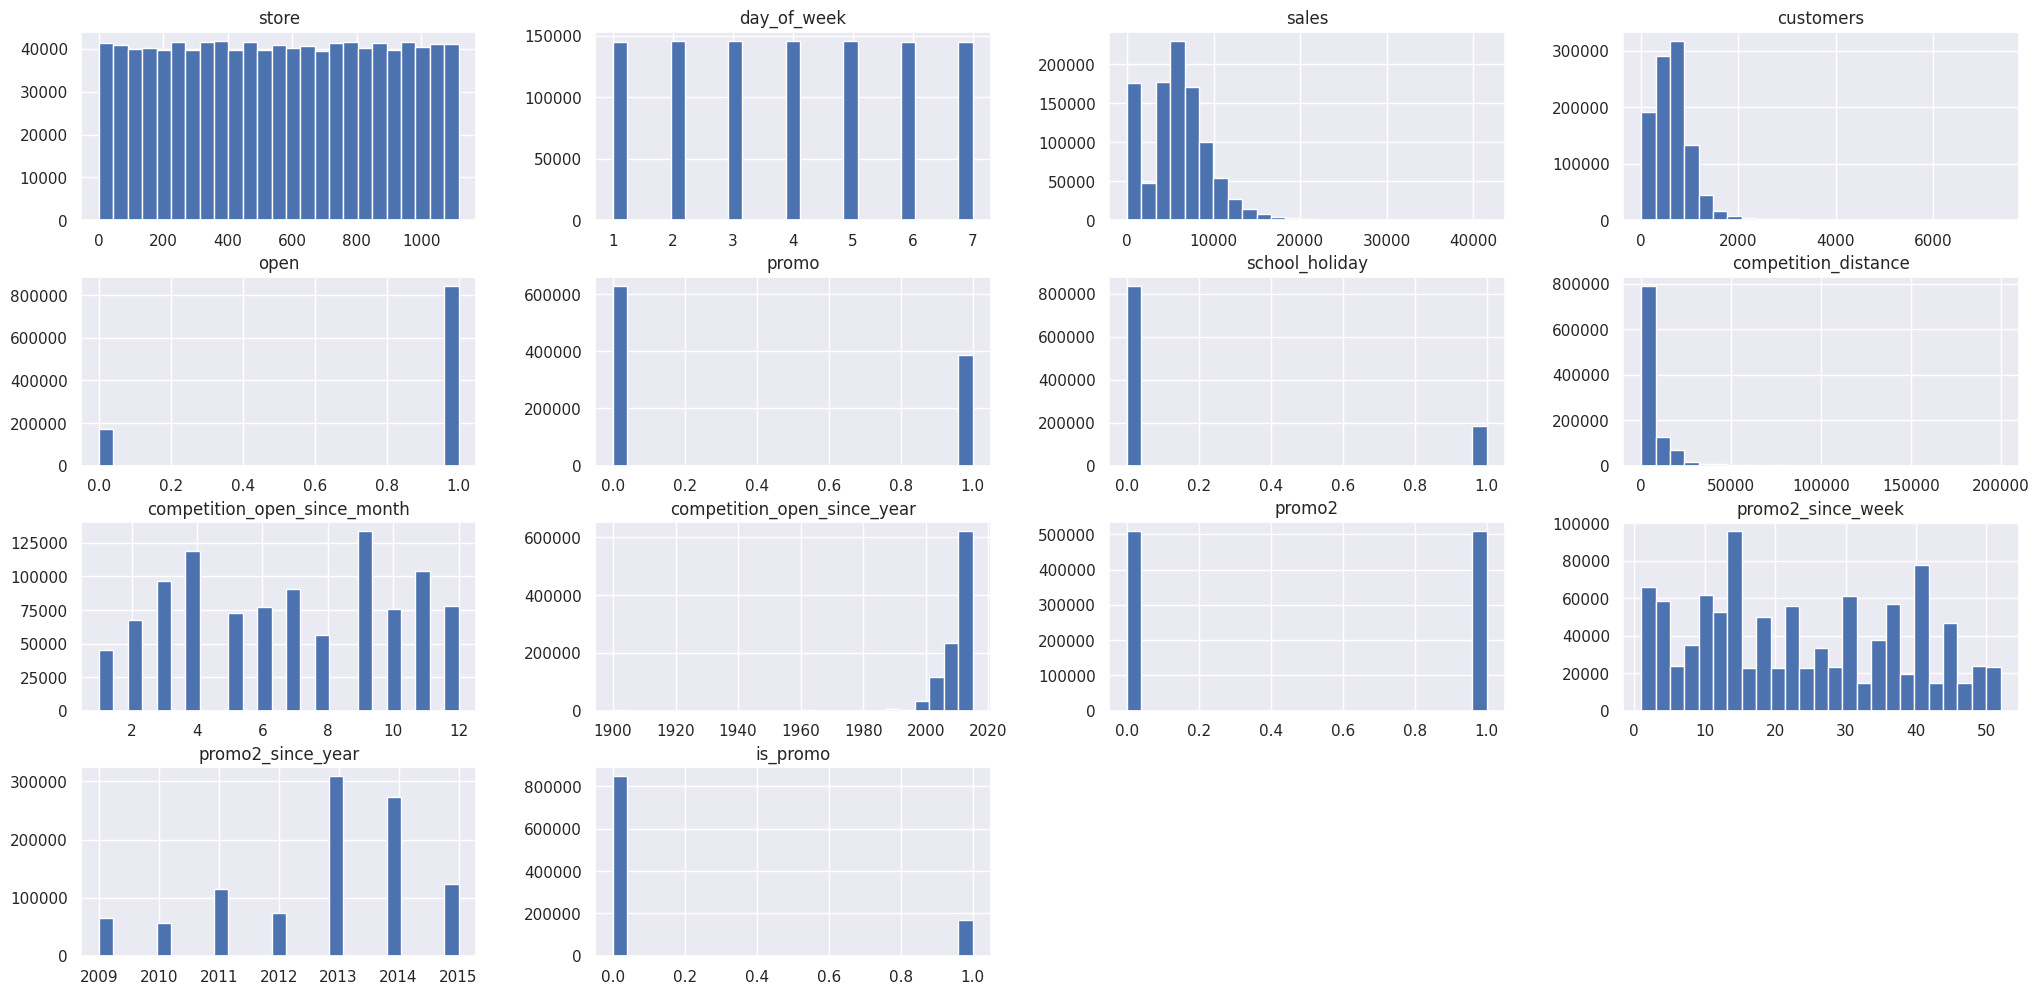

In [ ]:
# Como pode observar não existem gráficos com formato de normal ou Gaussina, portando não iremos aplicar o processo de normalização que tem a fórmula
# = (Xobservado - a média) / Desvio Padrão
num_atributes.hist( bins = 25)

## 6.2 Rescaling

In [ ]:
#Foram rescalados algumas colunas, que tinha um grande range elas são:
df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']]
# iremos verifica se existem muitos outliers, amos verificar cada coluna a quantidade de outliers, se tiver muito, trabalhamos o range por meio do
#RobustScaler, pois ele trabalha com na sua fórmula,  = o ponto local - primeiro quartil )/ terceiro quartil - primeiro quartil primeiro, se não pode
# usa o  MinMaxScaler(), sendo sua fórmula = (Xi(ponto observado) - Média )/ 3Quartil - 1 Quartil


In [ ]:
#sns.scatter(df5['competition_distance'])# uma forma de analisa a quantidade de utilier é quartil, mas meu pc não está coseguindo roda, então vamos
#sns.scatterplot( x='competition_distance', data=df5 )

In [ ]:
#sns.barplot(df5['competition_time_month'])

In [ ]:
#sns.barplot(df5['promo_time_week'])

In [ ]:
#df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']].head()

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )
# year
df5['year'] = mms.fit_transform( df5[['year']].values )

pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )


In [ ]:
df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']].head()

## 6.3 Transformação

### 6.3.1 Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [ ]:
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

0    2
1    0
2    0
3    2
4    0
Name: store_type, dtype: int64

In [ ]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p( df5['sales'] )

### 6.3.3.  Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )

df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )


In [ ]:
df5.head()


# 7. PASSO 07 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 7.1 Split dataframe into training and test dataset

In [ ]:
cols_drop =['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1)

In [ ]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train =  X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2 Boruta as Feature Selector


In [ ]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(֒X_train_n, y_train_n )
#o random_state é para manter um padrão de aleatoriedade cada vez que ele for fazer o processo.
# n_jobs são os parâmetros de núcleo, Se você definir n_jobs como -1, todos os núcleos da CPU

## 7.2.1

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,֒!cols_selected_boruta ) )

## 7.3 Manual Fature Selection

In [ ]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 8.0 PASSO 08 - MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[ cols_selected_boruta]
x_test  = X_test[ cols_selected_boruta ]

#Time Series Data Preparation

x_training =  X_train[ cols_selected_boruta_full]

## 8.1 Average Model

In [ ]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})

aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test ), np.expm1( yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train)

#prediction
yhat_lr = lr.predict( x_test)

#performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 8.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1980.04 +/- 0.0,0.28 +/- 0.0,2840.0 +/- 0.0


## 8.3.1. Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 8.3.1  Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2014.53 +/- 0.0,0.28 +/- 0.0,2918.82 +/- 0.0


## 8.4 Random Forest Regressor

In [ ]:
 # model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

## 8.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


## 8.5 XGBoost Regressor

In [ ]:
# modjel

model_xgb =  xgb.XGBRegressor( objective = 'reg:squarederror',
                                n_estimators = 100,
                               eta = 0.01,
                               max_depth = 10,
                               subsample = 0.7,
                               colsample_bytee = 0.9).fit( x_train, y_train)

# prediction

yhat_xgb = model_xgb.predict( x_test )

# performance

xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

## XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 8.6 Compare Model’s Performance

### 8.6.1  Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 8.6.2  Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

# 9.0 PASSO - HYPERPARAMETER FINE TUNING

## 9.1 Random Search

In [ ]:
#param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }
#
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
    # # choose values for parameters randomly
    # hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    # print( hp )
    ##
    # model
    # model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
    # n_estimators=hp['n_estimators'],
    # eta=hp['eta'],
    # max_depth=hp['max_depth'],
    # subsample=hp['subsample'],
    # colsample_bytee=hp['colsample_bytree'],
    # min_child_weight=hp['min_child_weight'] )
    ##
    # performance
    # result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,֒!verbose=True )
    # final_result = pd.concat( [final_result, result] )

#final_result

In [ ]:
#final_result

## 9.2  Final Model




"Encontrar o conjunto de parâmetros que maximiza o aprendizado do modelo."






In [ ]:
param_tuned = {
'n_estimators': 3000,
'eta': 0.03,
'max_depth': 5,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

# 10 PASSO - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

como entender a performance do Modelo e dizer para o CEO o quanto R$ esse modelo vai trazendo para a empresa ?

In [ ]:
df9 =  X_test[ cols_selected_boruta_full]

# rescale
df9['sales']       = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned)

## 10.1 Business Performance

In [ ]:
# SUM of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1= df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAE'})
df9_aux2= df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAPE'})

#Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how ='inner', on = 'store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head()

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 10.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:
 np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 10.3 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot(2, 2, 1 )
sns.lineplot( x= 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y= 'predicitions', data= df9, label = 'PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

#  11.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'C:\Users\Antonio Richard\OneDrive - acad.ifma.edu.br\Documentos\A Sala de aprendizado\DS Library Books\Meiga Material\DS_Producao\DS\model\model_rossmann.pkl', 'wb'))

## 11.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann( object ):
    def __init__( self ):
        self.home_paht = 'C:\Users\Antonio Richard\OneDrive - acad.ifma.edu.br\Documentos\A Sala de aprendizado\DS Library Books\Meiga Material\DS_Producao\DS'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ))
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning( self; df1):

      ## 1.1. Rename Columns
      cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 	'Promo','StateHoliday', 'SchoolHoliday',
      'StoreType', 'Assortment', 'CompetitionDistance',    'CompetitionOpenSinceMonth',
	    'CompetitionOpenSinceYear', 'Promo2', 	'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

      snakecase = lambda x: inflection.underscore( x )

      cols_new  = list( map(snakecase, cols_old ) )

      # rename
      df1.columns = cols_new

      ## 1.3. Data Types

      df1['date'] = pd.to_datetime( df1['date'])

      ## 1.5. Fillout NA
      # competition_distance
      df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if mant.isnan( x ) else x )

      #competition_open_since_month
      df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

      # #competition_open_since_year
      df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].֒year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

      #promo2_since_week
      df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] else x['promo2_since_week' ],  axis = 1 ))

      #promo2_since_year
      df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

      #promo_interval
      month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

      df1['promo_interval'].fillna(0, inplace=True )

      df1['month_map'] = df1['date'].dt.month.map( month_map )

      df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

      ## 1.6. Change Data Types

      # competiton

      df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

      df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

      # promo2
      df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
      df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
      return df1


      def feature_engineering( self, df2 ):
      # year

      df2['year'] = df2['date'].dt.year

      # month
      df2['month'] = df2['date'].dt.month


      # day
        df2['day'] = df2['date'].dt.day
      # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
      # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
      # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

      df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

      # promo since
      df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

      df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

      df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )


      # assortment
      df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

      # state holiday
      df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

      # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
      ## 3.1. Filtragem das Linhas
      df2 = df2[df2['open'] != 0]
      ## 3.2. Selecao das Colunas
      cols_drop = ['open', 'promo_interval', 'month_map']
      df2 = df2.drop( cols_drop, axis=1 )
      return df2

      def data_preparation( self, df5 ):

        ## 5.2. Rescaling
          # competition distance
          df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
          # competition time month
          df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
          # promo time week
          df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
          # year
          df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
          ### 5.3.1. Encoding
          # state_holiday - One Hot Encoding
          df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

          # store_type - Label Encoding
          df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
          # assortment - Ordinal Encoding
          assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

          df5['assortment'] = df5['assortment'].map( assortment_dict )

          ### 5.3.3. Nature Transformation
          # day of week
          df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2.   * np.pi/7 ) ) )
          df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7   ) ) )
          # month
          df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
          df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
          # day

          df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/ 30 ) ) )
          df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/ 30 ) ) )
          # week of year
          df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
          df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


          cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month',
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
          'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
          return df5[ cols_selected ]

          def get_prediction( self, model, original_data, test_data ):

            # prediction
            pred = model.predict( test_data )
            # join pred into the original data
            original_data['prediction'] = np.expm1( pred )
            return original_data.to_json( orient='records', date_format='iso' )

##  11.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
# loading model
model = pickle.load( open( 'C:\Users\Antonio Richard\OneDrive - acad.ifma.edu.br\Documentos\A Sala de aprendizado\DS Library Books\Meiga Material\DS_Producao\DS\model\model_rossmann.pkl', 'rb') )
# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods = ['POST'] )



def rossmann_predict():
  test_json = request.get_json()

  if test_json: # there is data
    if isinstance( test_json, dict ): # unique example
      test_raw = pd.DataFrame( test_json, index=[0] )

    else: # multiple example
      test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

    # Instantiate Rossmann class
    pipeline = Rossmann()

    # data cleaning
    df1 = pipeline.data_cleaning( test_raw )

    # feature engineering
    df2 = pipeline.feature_engineering( df1 )

    # data preparation
    df3 = pipeline.data_preparation( df2 )

    # prediction
    df_response = pipeline.get_prediction( model, test_raw, df3 )

    return df_response
  else:
    return Reponse( '{}', status=200, mimetype='application/json' )
if __name__ == '__main__':
   app.run( '0.0.0.0' )

## 11.3  API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'C:\Users\Antonio Richard\OneDrive - acad.ifma.edu.br\Documentos\A Sala de aprendizado\DS Library Books\Meiga Material\DS_Producao\DS\dataset\test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
d2.loc[i, 'store'],
d2.loc[i, 'prediction'] ) )